In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
from functional import seq
from tqdm.auto import tqdm

from utils import process_viztrace_json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context("talk")

## Reading and parsing data

In [5]:
df_mems = []
for file in tqdm(sorted(Path('benchmark_jsons').glob('*.json'))):
    try:
        df_mem, df_info = process_viztrace_json(file)
        df_mem[["toolkit", "index", "nb_traces", "n", "n_out", "headless"]] = (
            seq(file.name.split(".")[0].split("__"))
                .map(lambda x: x.split("=")[-1])
                .to_list()
        )
        df_mem[['index', 'nb_traces', 'n', 'n_out']] = df_mem[
            ['index', 'nb_traces', 'n', 'n_out']].astype(int)
        df_mem.loc[:df_info[df_info.name.str.contains('constructed image')].index[0],
        'phase'] = 'image construction'
        df_mem.loc[df_info[df_info.name.str.contains('constructed image')].index[0]:,
        'phase'] = 'rendering'
        df_mems.append(df_mem.reset_index())
    except Exception as e:
        print(file)
        print(e)

100%|██████████| 8217/8217 [05:21<00:00, 25.55it/s]


In [6]:
df_mem_tot = pd.concat(df_mems, ignore_index=True)
df_mem_tot['args.rss'] /= 1e6
df_mem_tot.rename(columns={'args.rss': 'memory (MB)'}, inplace=True)
df_mem_tot['ts'] = df_mem_tot.ts.dt.total_seconds()
df_mem_tot.rename(columns={'ts': 'duration (s)'}, inplace=True)

In [7]:
# df_mem_tot = pd.read_parquet("df_mem_tot_r.parquet")
df_mem_tot["n"] = df_mem_tot["n"].map(lambda x: f"{x:,}")

toolkit_mapping: dict = {
    "holoviews_LTTB": "HoloViews LTTB",
    "holoviews_rasterize": "HoloViews rasterize",
    "matplotlib": "Matplotlib",
    "plotly_resampler": "Plotly-Resampler",
}

df_mem_tot.toolkit = df_mem_tot.toolkit.map(lambda x: toolkit_mapping.get(x, x)).astype(
    "category"
)


In [8]:
df_mem_viz = (
    df_mem_tot.groupby(["toolkit", "index", "nb_traces", "n"])[
        ["duration (s)", "memory (MB)"]
    ]
    .max()
    .reset_index()
)

## The visualization

The visualization below uses a limited amount of traces (more realistic use-case)

### Benchmark figure (nb-traces < 50)

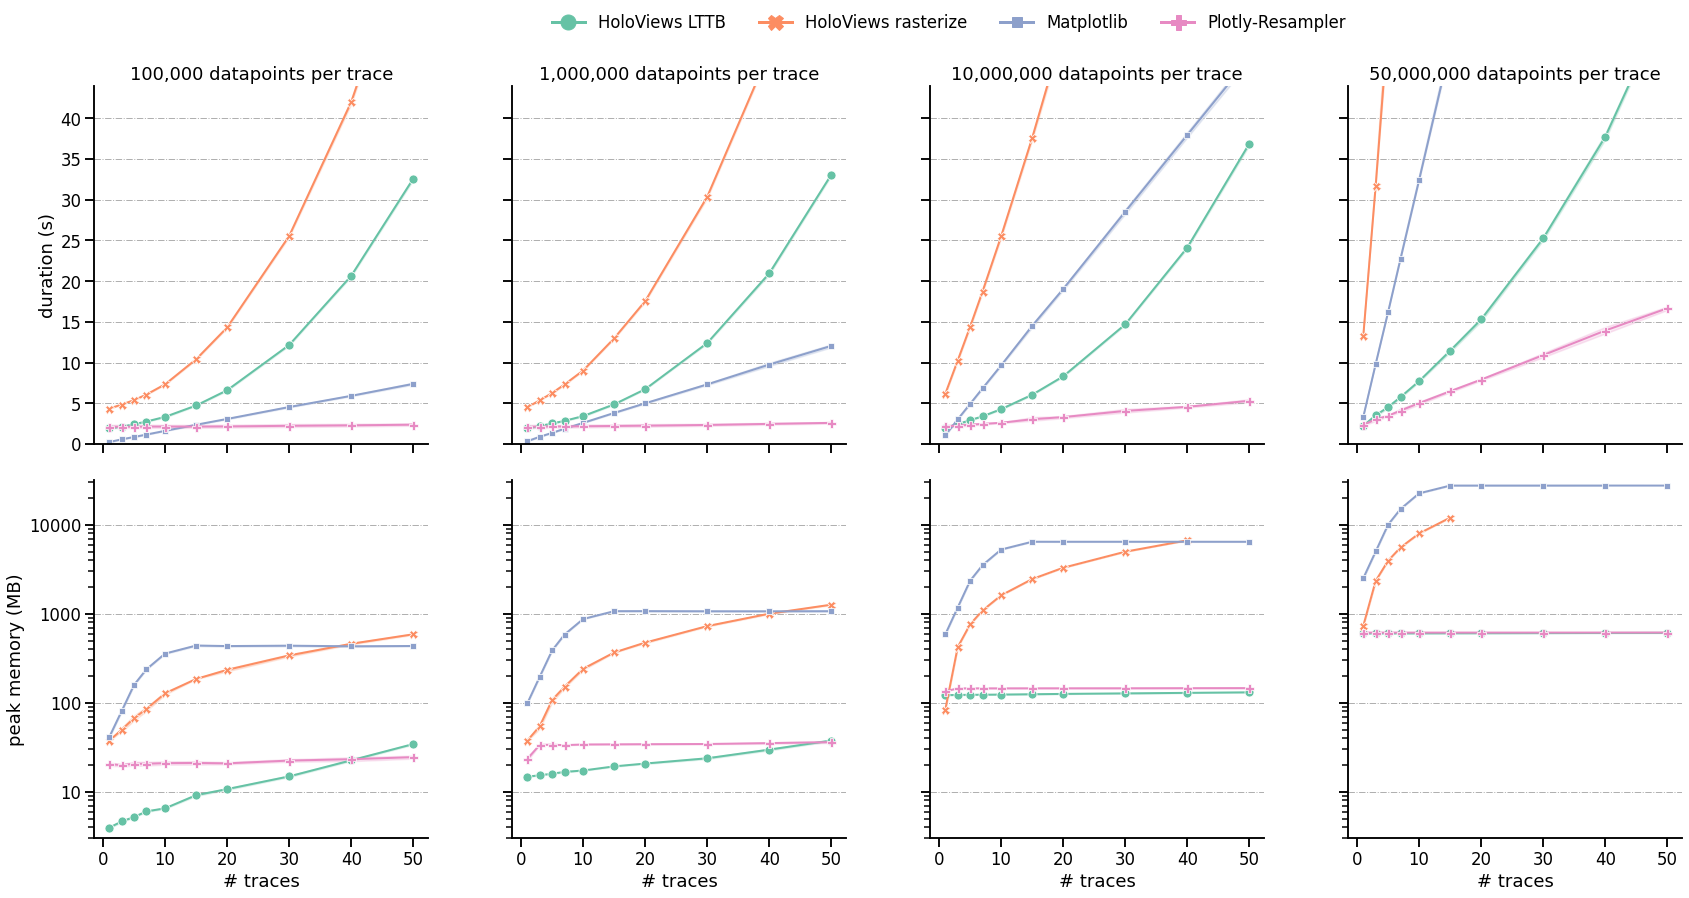

In [9]:
row_order = ["duration (s)", "peak memory (MB)"]
g = sns.relplot(
    data=df_mem_viz[df_mem_viz.nb_traces.isin([1, 3, 5, 7, 10, 15, 20, 30, 40, 50])]
    .rename(columns={"memory (MB)": "peak memory (MB)"})
    .melt(id_vars=["nb_traces", "toolkit", "index", "n"])
    .rename(
        columns={
            "nb_traces": "# traces",
            "n": "datapoints per trace",
        }
    ),
    kind="line",
    hue="toolkit",
    style="toolkit",
    x="# traces",
    row="variable",
    y="value",
    markers=True,
    dashes=False,
    height=6,
    palette="Set2",
    linewidth=2,
    col="datapoints per trace",
    col_order=["100,000", "1,000,000", "10,000,000", "50,000,000"],
    row_order=row_order,
    facet_kws={"sharey": "row"},  #'sharex': 'row'}
)

g.set_titles("{col_name} {col_var}")
for ax in g.axes[0]:
    ax.set_ylim(0, 44)
    ax.grid(True, axis="y", linewidth=1, linestyle="dashdot")


for ax in g.axes[1]:
    ax.grid(True, axis="y", linewidth=1, linestyle="dashdot")
    ax.set_ylim(3, 32_000)
    ax.set_title("")
    ax.set_yscale("log")
    ax.set_yticks([10, 100, 1000, 10_000])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

sns.move_legend(
    g, "lower center", bbox_to_anchor=(0.5, 1), ncol=4, title=None, frameon=False
)
plt.setp(g.legend.get_lines(), linewidth=3, markersize=15)

for row_axs, row_name in zip(g.axes, row_order):
    row_axs[0].set_ylabel(row_name)
plt.subplots_adjust(wspace=0.25, hspace=0.1)

In [10]:
g.savefig("../reports/benchmark_fig.pdf", dpi=250)
g.savefig("../reports/benchmark_fig.png", dpi=250)

### Benchmark figure (nb_traces < 200)

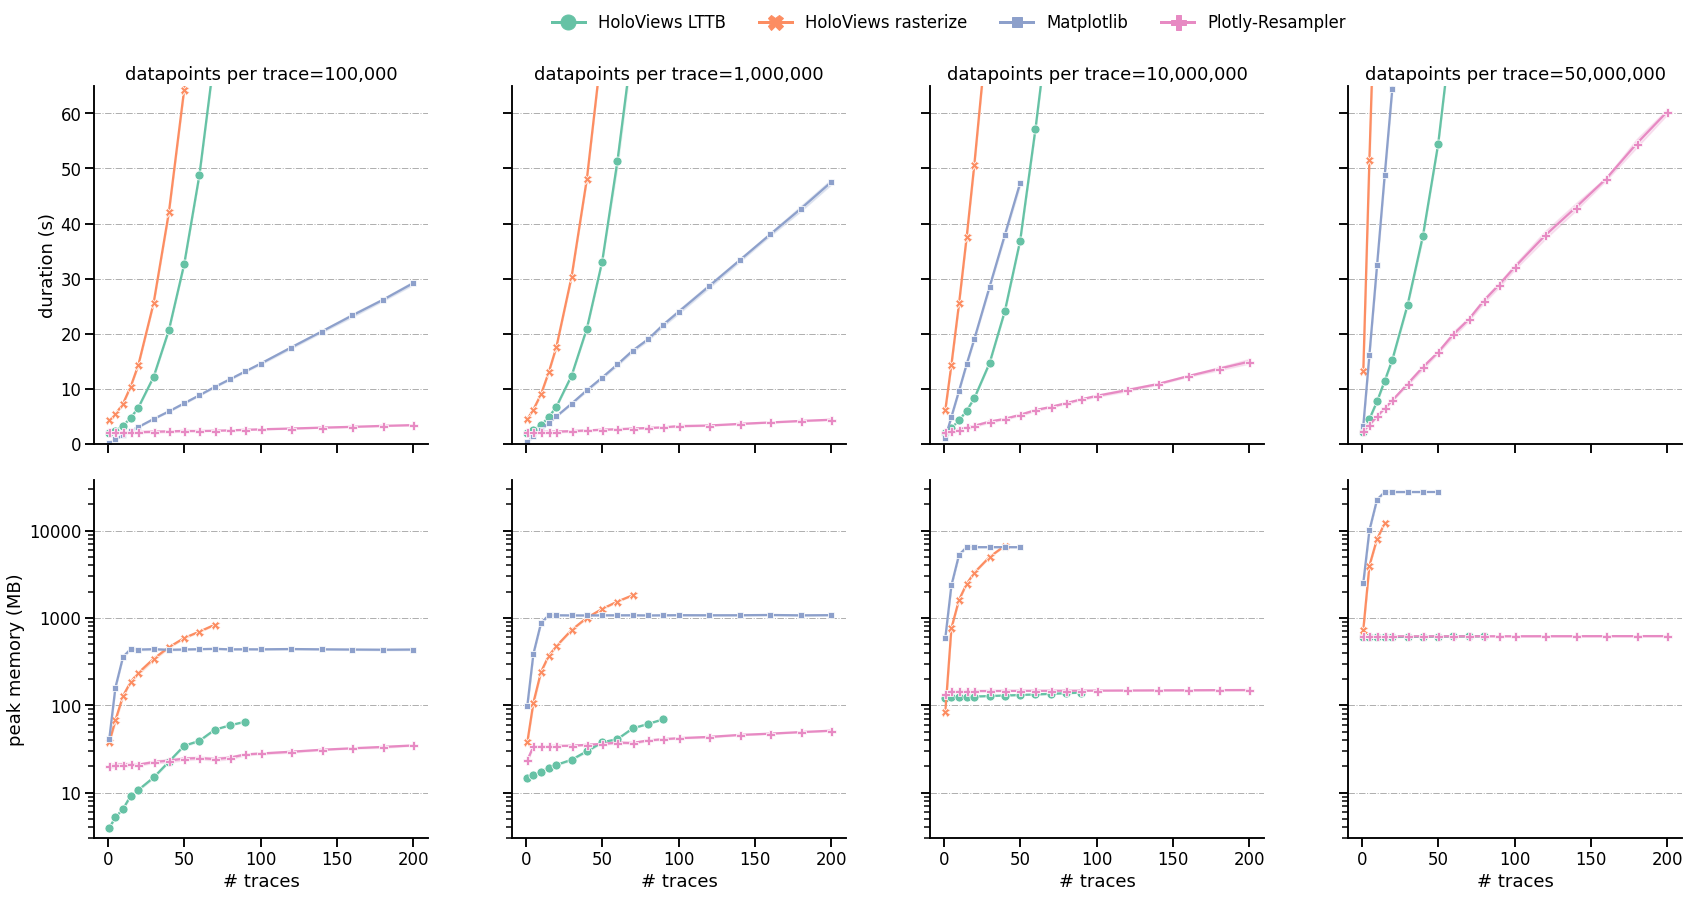

In [11]:
row_order = ["duration (s)", "peak memory (MB)"]
g = sns.relplot(
    data=df_mem_viz[
        df_mem_viz.nb_traces.isin(
            [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
        )
    ]
    .rename(columns={"memory (MB)": "peak memory (MB)"})
    .melt(id_vars=["nb_traces", "toolkit", "index", "n"])
    .rename(
        columns={
            "nb_traces": "# traces",
            "n": "datapoints per trace",
        }
    ),
    kind="line",
    hue="toolkit",
    style="toolkit",
    markers=True,
    dashes=False,
    x="# traces",
    y="value",
    row="variable",
    height=6,
    palette="Set2",
    col="datapoints per trace",
    col_order=["100,000", "1,000,000", "10,000,000", "50,000,000"],
    row_order=row_order,
    facet_kws={"sharey": "row"},
)
g.set_titles("{col_var}={col_name}")
plt.setp(g.legend.get_lines(), linewidth=3, markersize=15)
sns.move_legend(
    g, "lower center", bbox_to_anchor=(0.5, 1), ncol=4, title=None, frameon=False
)

for ax in g.axes[0]:
    ax.set_ylim(0, 65)
    ax.grid(True, axis="y", linewidth=1, linestyle="dashdot")

for ax in g.axes[1]:
    ax.grid(True, axis="y", linewidth=1, linestyle="dashdot")
    ax.set_ylim(3, 38_000)
    ax.set_yscale("log")
    ax.set_title("")
    # ax.set_yticks([10, 100, 1000, 5_000])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

for row_axs, row_name in zip(g.axes, row_order):
    row_axs[0].set_ylabel(row_name)

plt.subplots_adjust(wspace=0.25, hspace=0.1)

In [12]:
g.savefig("../reports/benchmark_fig_high_nb_traces.pdf", dpi=250)
g.savefig("../reports/benchmark_fig_high_nb_traces.png", dpi=250)

## Toolkit as column

In [13]:
data_sizes = (
    pd.Series(df_mem_viz["n"].unique())
    .str.replace(",", "")
    .astype(int)
    .sort_values()
    .map(lambda x: f"{x:,}")
    .to_list()
)
data_sizes[2:]


['100,000',
 '200,000',
 '500,000',
 '1,000,000',
 '2,000,000',
 '5,000,000',
 '10,000,000',
 '20,000,000',
 '50,000,000']

In [14]:
data_sizes[5:][::2] + data_sizes[-1:]

['1,000,000', '5,000,000', '20,000,000', '50,000,000']

### Low nb. of traces

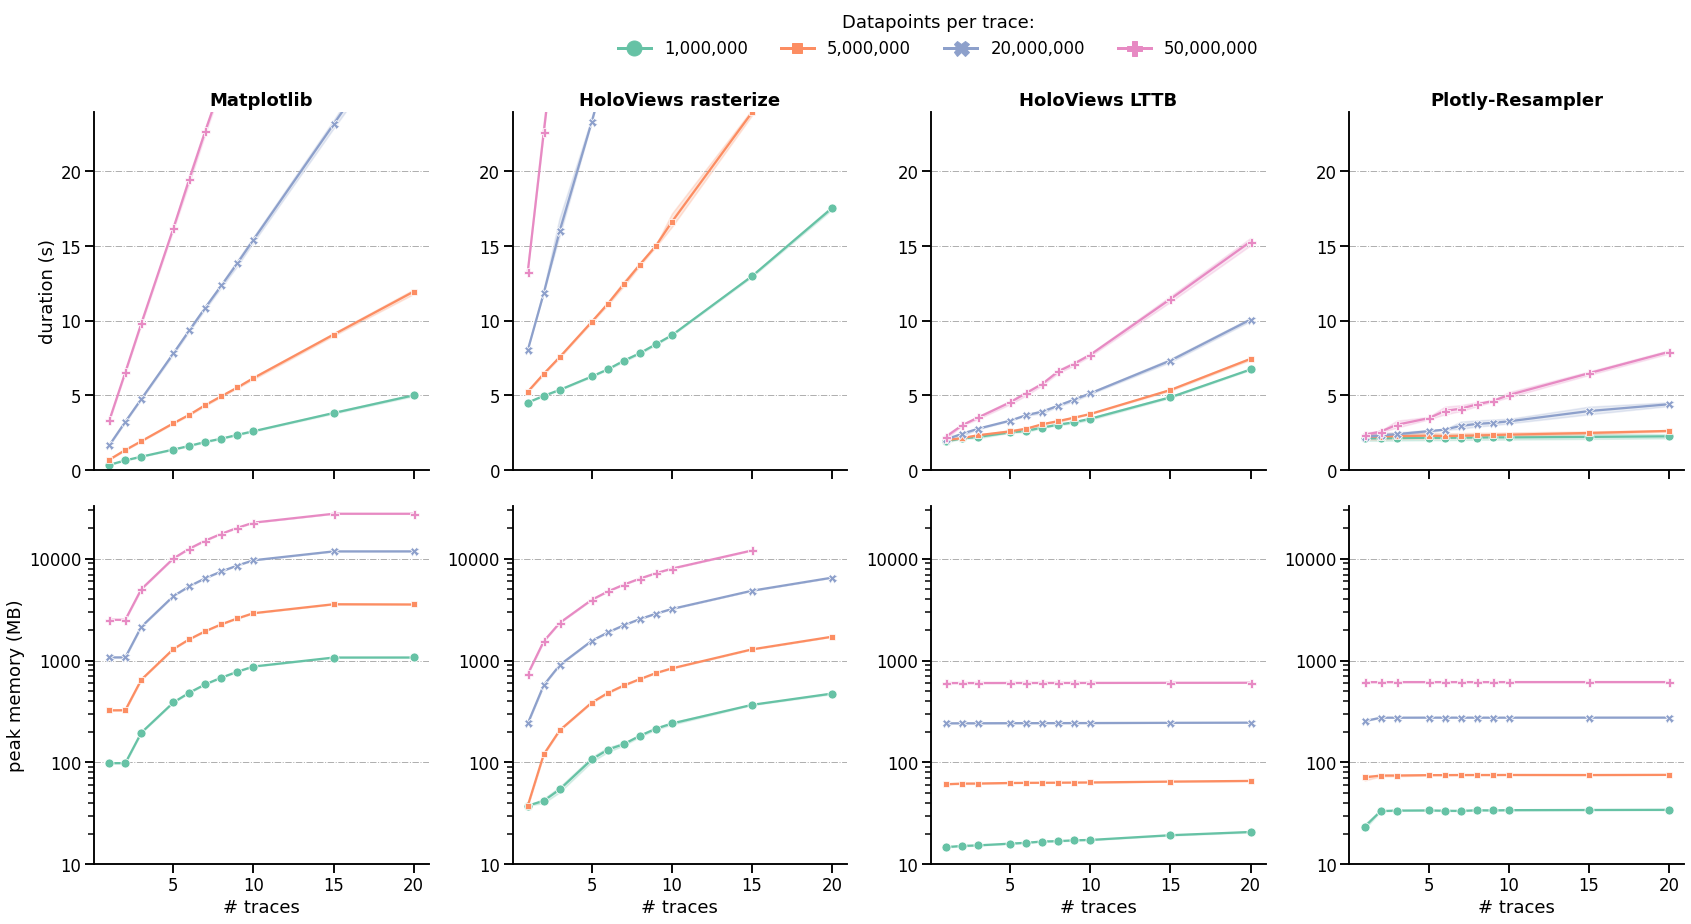

In [15]:
row_order = ["duration (s)", "peak memory (MB)"]
g = sns.relplot(
    data=df_mem_viz[
        (df_mem_viz.nb_traces < 30)
        & (df_mem_viz.nb_traces > 0)
        & (df_mem_viz.n.isin(data_sizes[5:][::2] + data_sizes[-1:]))
    ]
    .rename({"memory (MB)": "peak memory (MB)"})
    .melt(id_vars=["nb_traces", "toolkit", "index", "n"])
    .rename(
        columns={
            "nb_traces": "# traces",
            "n": "datapoints per trace",
        }
    ),
    kind="line",
    hue="datapoints per trace",
    style="datapoints per trace",
    markers=True,
    dashes=False,
    x="# traces",
    y="value",
    row="variable",
    height=6,
    palette="Set2",
    col="toolkit",
    col_order=[
        "Matplotlib",
        "HoloViews rasterize",
        "HoloViews LTTB",
        "Plotly-Resampler",
    ],
    hue_order=data_sizes[5:][::2] + data_sizes[-1:],
    facet_kws={"sharey": False},
)
g.set_titles("{col_name}")
plt.setp(g.legend.get_lines(), linewidth=3, markersize=15)
sns.move_legend(
    g,
    "lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=4,
    title="Datapoints per trace:",
    frameon=False,
)

for ax in g.axes[0]:
    ax.set_ylim(0, 24)
    # ax.set_xlim(0, 15)
    ax.set_title(ax.title.get_text(), fontdict=dict(fontweight="bold"))
    ax.grid(True, axis="y", linewidth=1, linestyle="dashdot")

for ax in g.axes[1]:
    ax.grid(True, axis="y", linewidth=1, linestyle="dashdot")
    ax.set_title("")
    # ax.set_xlim(0, 15)
    ax.set_ylim(10, 33_000)
    ax.set_yscale("log")
    # ax.set_yticks([10, 100, 1000, 5_000])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

for row_axs, row_name in zip(g.axes, row_order):
    row_axs[0].set_ylabel(row_name)

plt.subplots_adjust(wspace=0.25, hspace=0.1)


In [16]:
g.savefig("../reports/benchmark_fig_low_nb_traces_scaling.png", dpi=250)

### Large nb. of traces

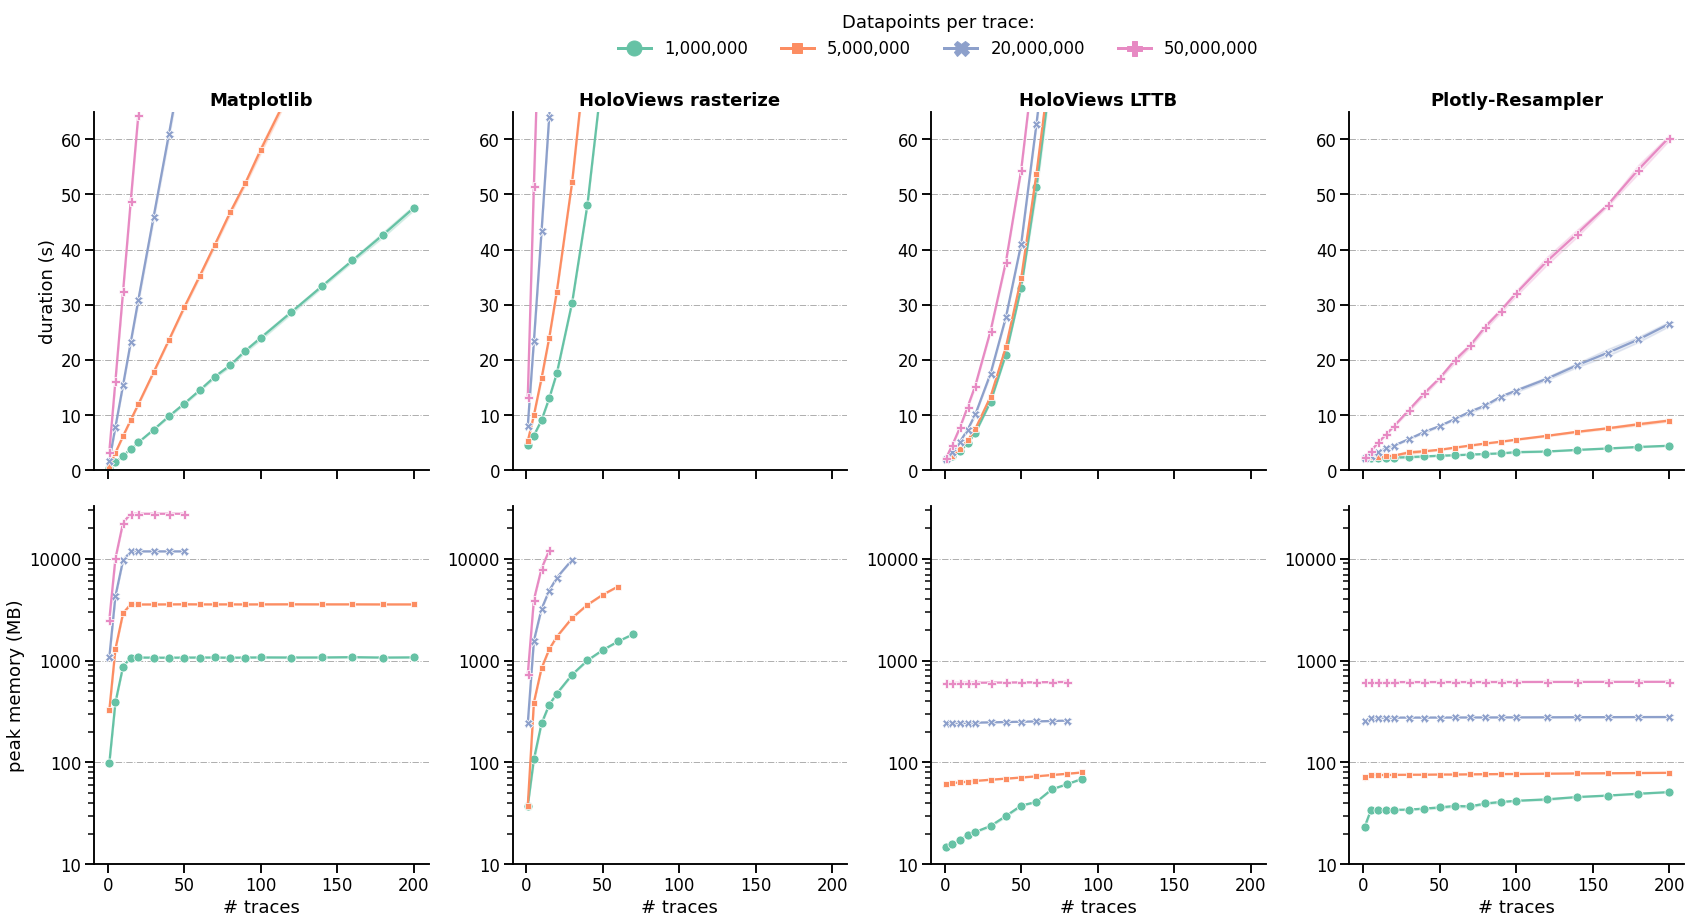

In [17]:
row_order = ["duration (s)", "peak memory (MB)"]
g = sns.relplot(
    data=df_mem_viz[
        df_mem_viz.nb_traces.isin(
            [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
        )
        & (df_mem_viz.n.isin(data_sizes[5:][::2] + data_sizes[-1:]))
    ]
    .rename({"memory (MB)": "peak memory (MB)"})
    .melt(id_vars=["nb_traces", "toolkit", "index", "n"])
    .rename(
        columns={
            "nb_traces": "# traces",
            "n": "datapoints per trace",
        }
    ),
    kind="line",
    hue="datapoints per trace",
    style="datapoints per trace",
    markers=True,
    dashes=False,
    x="# traces",
    y="value",
    row="variable",
    height=6,
    palette="Set2",
    col="toolkit",
    col_order=[
        "Matplotlib",
        "HoloViews rasterize",
        "HoloViews LTTB",
        "Plotly-Resampler",
    ],
    hue_order=data_sizes[5:][::2] + data_sizes[-1:],
    facet_kws={"sharey": False},
)
g.set_titles("{col_name}")
plt.setp(g.legend.get_lines(), linewidth=3, markersize=15)
sns.move_legend(
    g,
    "lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=4,
    title="Datapoints per trace:",
    frameon=False,
)

for ax in g.axes[0]:
    ax.set_ylim(0, 65)
    ax.set_title(ax.title.get_text(), fontdict=dict(fontweight="bold"))
    # ax.set_yscale('log')
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.grid(True, axis="y", linewidth=1, linestyle="dashdot")

for ax in g.axes[1]:
    ax.grid(True, axis="y", linewidth=1, linestyle="dashdot")
    ax.set_ylim(10, 33_000)
    ax.set_yscale("log")
    ax.set_title("")
    # ax.set_yticks([10, 100, 1000, 5_000])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

for row_axs, row_name in zip(g.axes, row_order):
    row_axs[0].set_ylabel(row_name)

plt.subplots_adjust(wspace=0.25, hspace=0.1)

In [18]:
g.savefig("../reports/benchmark_fig_high_nb_traces_scaling.png", dpi=250)